# Game theory programming assignment

##### We shall use terminology and symbols from the Wikipedia article on the GIbbard-Sattherhwaite theorem

![definitions](definitions.png "Title")

In [1]:
import copy
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.auto import tqdm
from itertools import product
import pickle

In [2]:
from typing import Dict, List
# Type hints for the entities
Candidate = int
Voter = int
Preference = List[Candidate]
PreferencesProfile = List[List[Candidate]]
CandidateScores = Dict[Candidate,Candidate]

In [3]:
# Voting rules
# All voting rules take as input an array of same sized arrays of alteratives
# Each alternative is an integer defining the candidate (0,..,n)
# Each voting rule returns one alternative which is the winner
def plurality(Plist : PreferencesProfile) -> CandidateScores:
    num_alts = len(Plist[0])  
    alt2count = {}
    for P in Plist:
        if len(P) != num_alts:
            raise Exception("The preferences of each voter must be the same length")
        alt = P[0]
        for nalt in P:
            if nalt not in alt2count:
                alt2count[nalt] = 0
        alt2count[alt] +=1
    return dict(sorted(alt2count.items(), key=lambda item: item[1], reverse=True))

def borda(Plist : PreferencesProfile) -> CandidateScores:
    num_alts = len(Plist[0])
    alt2count = {}
    for P in Plist:
        if len(P) != num_alts:
            raise Exception("The preferences of each voter must be the same length")
        for i, alt in enumerate(P):
            if alt not in alt2count:
                alt2count[alt] = 0
            alt2count[alt] += num_alts - i -1
    return dict(sorted(alt2count.items(), key=lambda item: item[1], reverse=True))

from typing import List,Tuple
def winner_from_scores(score_list : CandidateScores) -> Candidate:
    slist = sorted(score_list.items(), key=lambda x: int(str(x[1])), reverse=True)
    winners = []
    top_score = slist[0][1]
    for k,v in slist:
        if v != top_score:
            break
        winners.append(k)
    # Returns the winner with the smallest index
    return min(winners)
def ranking_from_scores(score_list : Dict[int,int])-> List[List[Candidate]]:
    """
    Returns an array with the places of the candidates.
    At each position i the candidates that placed i-th are located in a list
    """
    score2candidate = {}
    for k,v in score_list.items():
        if v not in score2candidate:
            score2candidate[v] = []
        score2candidate[v].append(k)
    places = sorted(score2candidate.items(), key= lambda x : x[0] , reverse=True )
    return [x[1] for x in places]
    

##### Defining the strategies

In [4]:
# Utility function of each voter (ranking of alternatives)
def u(true_preferences : PreferencesProfile, voter : Voter, candidate: Candidate):
    return len(true_preferences[voter]) - true_preferences[voter].index(candidate) -1

#### Plurality strategy 

A voter $v$ with true preference $P$ and voting ballot $P'$ can manipulate election with the plurality voting rule if all of the following is true:

* there exists $a'$ which is different than the winner $a$ s.t. $u_v(a') > u_v(a)$
* $v$ didn't vote for $a'$
* if $v$ votes for $a'$ instead of his previous vote $a''$ the winner is $a'$


In [5]:
# Helper function for changing ballots
def swap_alternatives(P , a1, a2):
    Pcopy = copy.deepcopy(P)
    index1 = Pcopy.index(a1)
    index2 = Pcopy.index(a2)
    Pcopy[index1] , Pcopy[index2] = Pcopy[index2] , Pcopy[index1]
    return Pcopy

In [6]:
from functools import partial
def plurality_manipulation(true_preferences : PreferencesProfile,
                           current_ballots  : PreferencesProfile,
                           voter_i          : Voter):
    """
    Returns the ballot with which the voter_i can manipulate the election or returns 
    None if the voter can not manipulate the election
    """
    ufunc = partial(u, true_preferences , voter_i)
    scores : CandidateScores = plurality(current_ballots)
    winner : Candidate = winner_from_scores(scores)
    top_vote = current_ballots[voter_i][0]
    # Skip unneded computation for voters of the winner
    if top_vote == winner:
        return
    # Find alternative satisfying the conidties
    for alternative in current_ballots[voter_i]:
        
        cond1 = (ufunc(alternative) > ufunc(winner))
        cond2 = (top_vote != alternative)
        # Dont compute the third condition if the first two are not met
        if not cond1 or not cond2:
            continue
            
        temp_current_ballots = copy.deepcopy(current_ballots)
        # Swap the new alternative and the old alternative in the ballto
        new_voter_ballot = swap_alternatives(temp_current_ballots[voter_i], alternative, top_vote)
        temp_current_ballots[voter_i] = new_voter_ballot
        
        cond3 = (winner_from_scores(plurality(temp_current_ballots)) == alternative)
        if cond3:
            return new_voter_ballot
        
# Test cases 



#### Borda manipulation 

A voter $v$ with true preference P and voting preference P' can manipulate an election with the borda rule iff all the following are true:

* An alternative $a'$ is preferred over the winner $a$
* $u_v(a') > u_v(a)$
* $a'$ is not at the top of $v$'s ballot or $a$ is not at the bottom of the ballot.
* By placing $a'$ at the top and $a$ at the bottom of $v$'s ballot, $a'$ becomes the winner

In [7]:
def borda_manipulation(true_preferences : PreferencesProfile,
                           current_ballots  : PreferencesProfile,
                           voter_i          : Voter):
    """
    Returns None if no manipulation can be made for voter_i otherwise returns 
    the new voter's ballots
    """
    """
    Returns the ballot with which the voter_i can manipulate the election or returns 
    None if the voter can not manipulate the election
    """
    ufunc = partial(u, true_preferences , voter_i)
    scores : CandidateScores = borda(current_ballots)
    winner : Candidate = winner_from_scores(scores)
    top_vote = current_ballots[voter_i][0]
    bottom_vote = current_ballots[voter_i][-1] 
    # Skip uneeded computation for voters of the winner
    if top_vote == winner:
        return
    # Find alternative satisfying the coniditions
    for alternative in current_ballots[voter_i]:

        cond1 = (ufunc(alternative) > ufunc(winner))
        cond2 = (top_vote != alternative) or (bottom_vote != winner)
        # Dont compute the third condition if the first two are not met
        if not cond1 or not cond2:
            continue
        temp_current_ballots = copy.deepcopy(current_ballots)
        # Swap the new alternative and the old alternative in the ballto
        new_voter_ballot = swap_alternatives(temp_current_ballots[voter_i], bottom_vote, winner)
        new_voter_ballot = swap_alternatives(new_voter_ballot, alternative, top_vote)
        temp_current_ballots[voter_i] = new_voter_ballot
        cond3 = (winner_from_scores(borda(temp_current_ballots)) == alternative)
        if cond3:
            return new_voter_ballot
   

##### Defining the iterative process

In [8]:
# Best response dynamics
def best_response_dynamics(true_preferences, voting_rule, manipulation_func, Tmax):
    """
    Best response dynamics iterative algorithm.
    """
    true_preferences_chk = copy.deepcopy(true_preferences)
    current_preferences = copy.deepcopy(true_preferences)
    number_of_alts = len(true_preferences[0])
    for p in true_preferences:
        assert len(p)==number_of_alts , "Every ballot must have same number of alts"
    steps = 0
    converged = False
    price_of_anarchy = None
    
    for steps in range(Tmax):
        #print(f"Iteration {steps}")
        #print("Current preferences")
        #pprint(current_preferences)
        #print("Current scores : " , voting_rule(current_preferences) )
        no_manipulations = True
        for p in current_preferences:
            assert len(p)==number_of_alts , "Every ballot must have the same number of alts"
       # print("Current preferences ")
        #pprint(current_preferences)
        for i,_ in enumerate(current_preferences):
            new_preference = manipulation_func(
                true_preferences, current_preferences, i)
           # print(f"New preference for {i} is {new_preference} ")
            if new_preference == None:
                continue
            else:
                no_manipulations = False
                current_preferences[i] = new_preference
                break
        # Exit rule if an equillibrium has been reached
        if no_manipulations:
            converged = True
            
            # Calculate price of anarchy
            current_winner = winner_from_scores(voting_rule(current_preferences))
            current_winner_true_score = voting_rule(true_preferences)[current_winner]

            true_winner = winner_from_scores(voting_rule(true_preferences))
            true_winner_true_score = voting_rule(true_preferences)[true_winner]
            price_of_anarchy = abs(true_winner_true_score - current_winner_true_score)
            #print("price of anarchy ", price_of_anarchy)
            break
    
    
    assert true_preferences_chk == true_preferences, "True preferences should not be modified"
    return {
        'final_preferences' : current_preferences,
        'steps' : steps,
        'converged' : converged,
        'final_scores' : voting_rule(current_preferences),
        'winner' : winner_from_scores(voting_rule(current_preferences)),
        'price_of_anarchy' : price_of_anarchy
    }       


In [9]:
# Function to check if the final preferences have converged to a 2 party election
def preferences_have_2_outcomes(Plist):
    alts = set()
    for P in Plist:
        alts.add(P[0])
    return len(alts) == 2
        

# Creating random games for n,m

In [10]:
import numpy as np
from statistics import mean
def generate_random_games(n , m , verbose=True):
    """
    Generate random games and return aggregate statistics about those random games
    """
    assert n >= 5
    assert m >= 5
    borda_steps = []
    borda_converged = []
    borda_poas = []
    borda_converged_to_2 = []
    
    plurality_steps = []
    plurality_converged =[]
    plurality_poas = []
    plurality_converged_to_2 = []
    
    generator = list(range(30))
    if verbose:
        generator = tqdm(generator)
    for i in generator:
        alternatives = list(range(m))
        true_prefs = []
        for i in range(n):
            true_prefs.append(list(np.random.permutation(alternatives)))
        #print("Running for plurality ",'='*30)
        true_prefs_chk = copy.deepcopy(true_prefs)
        pres =best_response_dynamics(true_prefs, plurality, plurality_manipulation, 1000)
        plurality_converged.append(pres['converged'])
        final_preferences = pres['final_preferences']
        if pres['converged']:
            plurality_steps.append(pres['steps'])
            plurality_poas.append(pres['price_of_anarchy'])
            plurality_converged_to_2.append(
                1 if preferences_have_2_outcomes(final_preferences) else 0)
        
            #pprint("True preferences")
            #pprint(true_prefs)
            #pprint("Final preferences")
            #pprint(final_preferences)
            #print("Final scores " , plurality(final_preferences))
        
        #print("Running for borda ",'='*30)
        bres = best_response_dynamics(true_prefs, borda, borda_manipulation, 1000)
        borda_converged.append(bres['converged'])
        final_preferences = bres['final_preferences']
        if bres['converged']:
            borda_steps.append(bres['steps'])
            borda_poas.append(bres['price_of_anarchy'])
            borda_converged_to_2.append(
                1 if preferences_have_2_outcomes(final_preferences) else 0)
            #pprint("True preferences")
            #pprint(true_prefs)
            #pprint("Final preferences")
            #pprint(final_preferences)
            #print("Final scores " , borda(final_preferences))
        assert true_prefs_chk == true_prefs , "True preferences must not be modified"
    return {
        'borda_avg_steps' : mean(borda_steps),
        'borda_converge_freq' : mean([1 if x else 0 for x in borda_converged]),
        'borda_avg_poa' : mean(borda_poas),
        'borda_converge_to_2' : mean(borda_converged_to_2),
        'plurality_avg_steps' : mean(plurality_steps),
        'plurality_converge_freq' : mean([1 if x else 0 for x in plurality_converged]),
        'plurality_avg_poa' : mean(plurality_poas),
        'pluraltiy_converge_to_2' : mean(plurality_converged_to_2)
    }

In [12]:
generate_random_games(10, 5 , verbose=True)

{'borda_avg_steps': 2.4545454545454546,
 'borda_converge_freq': 0.7333333333333333,
 'borda_avg_poa': 0.5454545454545454,
 'borda_converge_to_2': 0.09090909090909091,
 'plurality_avg_steps': 1.8333333333333333,
 'plurality_converge_freq': 1,
 'plurality_avg_poa': 0.13333333333333333,
 'pluraltiy_converge_to_2': 0.23333333333333334}

In [13]:
# Paralellizing experiments with ray
import ray
import time
from random import random

/home/sm/.local/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [14]:
ray.init()

2021-06-04 22:31:36,875	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.19.89.182',
 'raylet_ip_address': '172.19.89.182',
 'redis_address': '172.19.89.182:6379',
 'object_store_address': '/tmp/ray/session_2021-06-04_22-31-35_145982_92592/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-04_22-31-35_145982_92592/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-04_22-31-35_145982_92592',
 'metrics_export_port': 49820,
 'node_id': 'acc400f22d2f1a445571b03120f4aafab8b9fc8a8307ae5a724caa2a'}

In [15]:
@ray.remote
def f(n,m):
    results = generate_random_games(n,n, verbose=False)
    return results
Ns = [10 , 20 , 30 , 40 , 50]
Ms = Ns

In [16]:
futures = { (n,m) : f.remote(n,m) for n,m in product(Ns,Ms)}

In [17]:
results = { k : ray.get(v) for k,v in futures.items()}

In [18]:
results

{(10, 10): {'borda_avg_steps': 4.863636363636363,
  'borda_converge_freq': 0.7333333333333333,
  'borda_avg_poa': 1.0909090909090908,
  'borda_converge_to_2': 0,
  'plurality_avg_steps': 3.2333333333333334,
  'plurality_converge_freq': 1,
  'plurality_avg_poa': 0.26666666666666666,
  'pluraltiy_converge_to_2': 0.23333333333333334},
 (10, 20): {'borda_avg_steps': 6.321428571428571,
  'borda_converge_freq': 0.9333333333333333,
  'borda_avg_poa': 2.392857142857143,
  'borda_converge_to_2': 0,
  'plurality_avg_steps': 2.466666666666667,
  'plurality_converge_freq': 1,
  'plurality_avg_poa': 0.2,
  'pluraltiy_converge_to_2': 0.23333333333333334},
 (10, 30): {'borda_avg_steps': 6.133333333333334,
  'borda_converge_freq': 0.5,
  'borda_avg_poa': 2.3333333333333335,
  'borda_converge_to_2': 0,
  'plurality_avg_steps': 3.6,
  'plurality_converge_freq': 1,
  'plurality_avg_poa': 0.3333333333333333,
  'pluraltiy_converge_to_2': 0.36666666666666664},
 (10, 40): {'borda_avg_steps': 5.55,
  'borda_c

In [19]:
with open("gt_results", "wb") as f:
    pickle.dump(results,f)

In [20]:
with open("gt_results", "rb") as f:
    results = pickle.load(f)

In [21]:
# Analytical results for each metric on each data point
results

{(10, 10): {'borda_avg_steps': 4.863636363636363,
  'borda_converge_freq': 0.7333333333333333,
  'borda_avg_poa': 1.0909090909090908,
  'borda_converge_to_2': 0,
  'plurality_avg_steps': 3.2333333333333334,
  'plurality_converge_freq': 1,
  'plurality_avg_poa': 0.26666666666666666,
  'pluraltiy_converge_to_2': 0.23333333333333334},
 (10, 20): {'borda_avg_steps': 6.321428571428571,
  'borda_converge_freq': 0.9333333333333333,
  'borda_avg_poa': 2.392857142857143,
  'borda_converge_to_2': 0,
  'plurality_avg_steps': 2.466666666666667,
  'plurality_converge_freq': 1,
  'plurality_avg_poa': 0.2,
  'pluraltiy_converge_to_2': 0.23333333333333334},
 (10, 30): {'borda_avg_steps': 6.133333333333334,
  'borda_converge_freq': 0.5,
  'borda_avg_poa': 2.3333333333333335,
  'borda_converge_to_2': 0,
  'plurality_avg_steps': 3.6,
  'plurality_converge_freq': 1,
  'plurality_avg_poa': 0.3333333333333333,
  'pluraltiy_converge_to_2': 0.36666666666666664},
 (10, 40): {'borda_avg_steps': 5.55,
  'borda_c

In [22]:
%matplotlib notebook

In [23]:
def plot2dmetric(metric): 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.array([x[0] for x in results.keys()])
    X, Y = np.meshgrid(x, y)
    def fun(x,y):
        return [results[(xi,yi)][metric] for xi ,yi in zip(x,y)]
    zs = np.array(fun(np.ravel(X), np.ravel(Y)))
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_xlabel('N')
    ax.set_ylabel('M')
    ax.set_zlabel('Z')
    plt.show()

In [24]:
list(results.items())[0][1].keys()

dict_keys(['borda_avg_steps', 'borda_converge_freq', 'borda_avg_poa', 'borda_converge_to_2', 'plurality_avg_steps', 'plurality_converge_freq', 'plurality_avg_poa', 'pluraltiy_converge_to_2'])

# Results

From the results we can conclude
* Best response dynamics with the plurality rule converges. With the borda voting rule the converge has a large frequency for smaller games which decreases as the game gets larger. 
* When the algorithm converges, the borda profile fluctuates between 4 and 10 average ballot manipulations. The same cannot be said for the plurality profile as there is a clear linear increase from around 5 ballot manipulations to 35 depending on the number of participants $N$. 
* The average price of anarchy for the borda profile alightly increases with N and for the plurality profile it seems to be uncorrelated with $N$,$M$ 

<IPython.core.display.Javascript object>


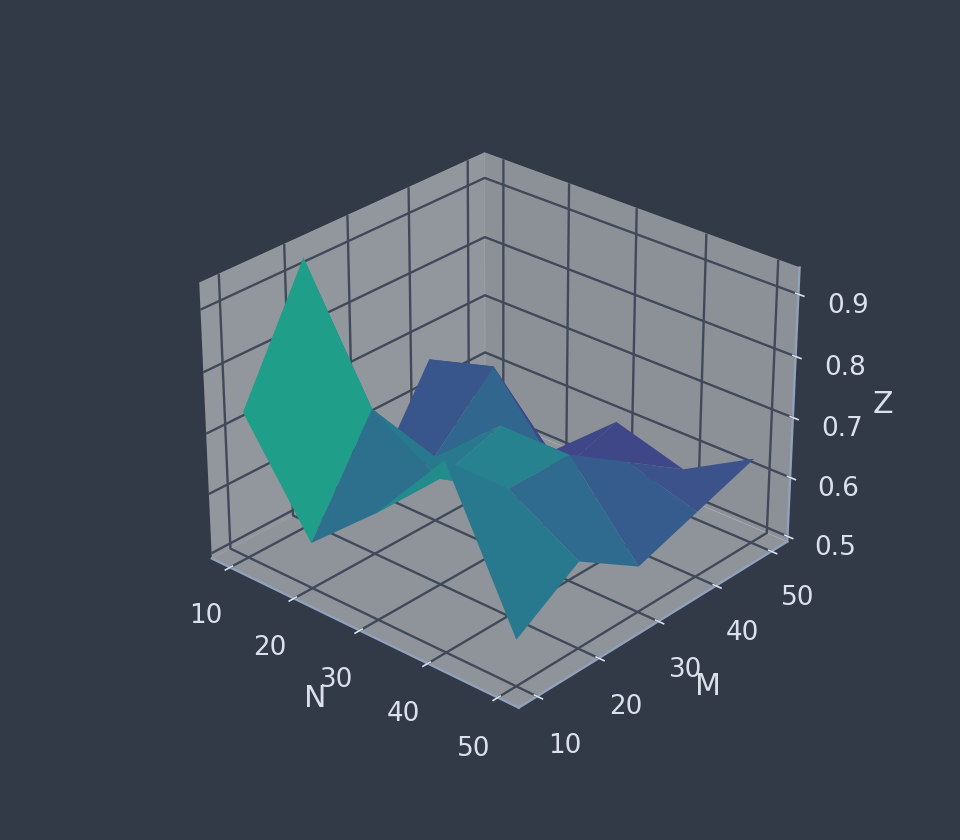

In [25]:
plot2dmetric('borda_converge_freq')

<IPython.core.display.Javascript object>


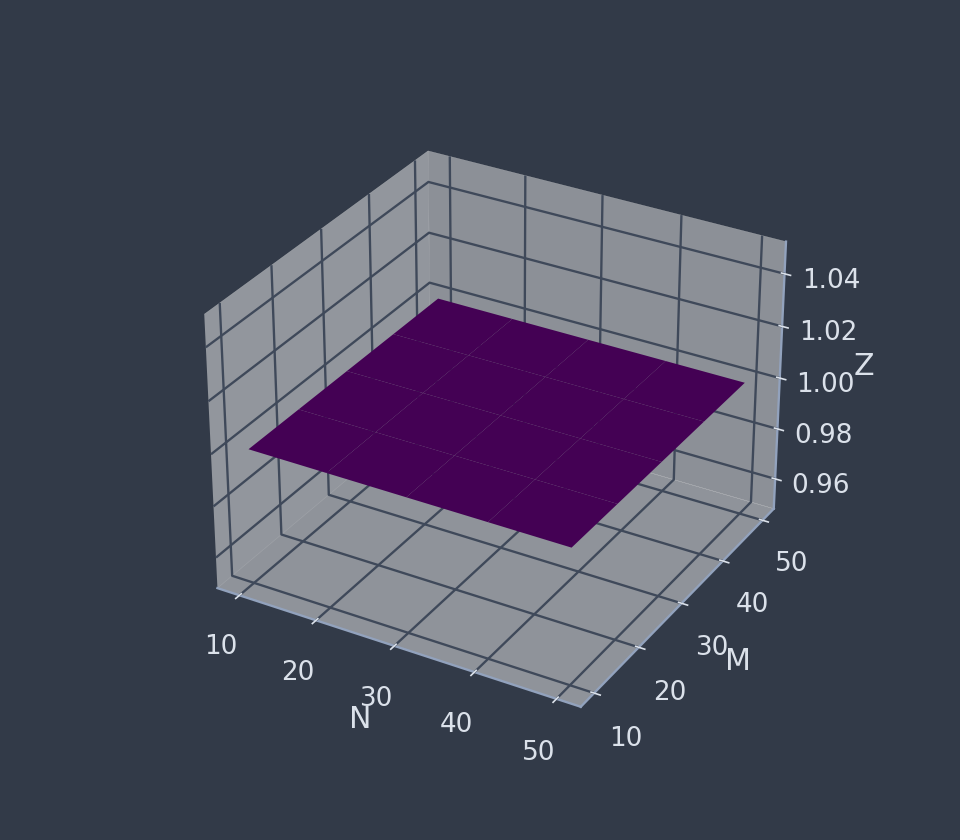

In [26]:
plot2dmetric('plurality_converge_freq')

<IPython.core.display.Javascript object>


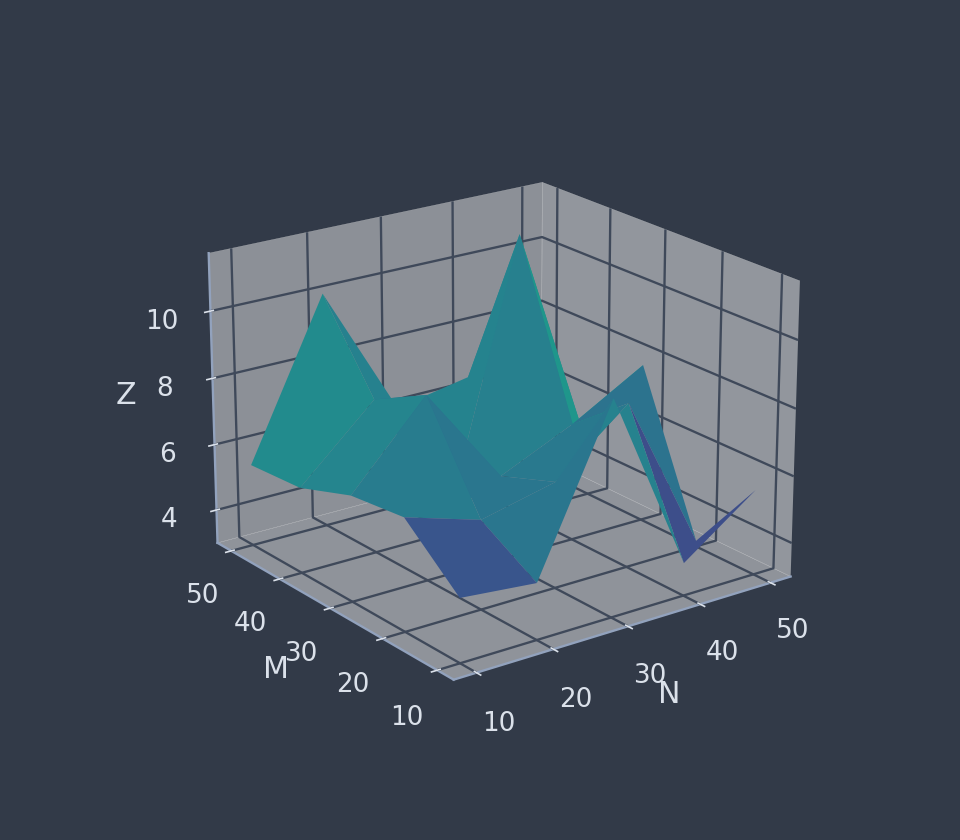

In [27]:
plot2dmetric('borda_avg_steps')

<IPython.core.display.Javascript object>


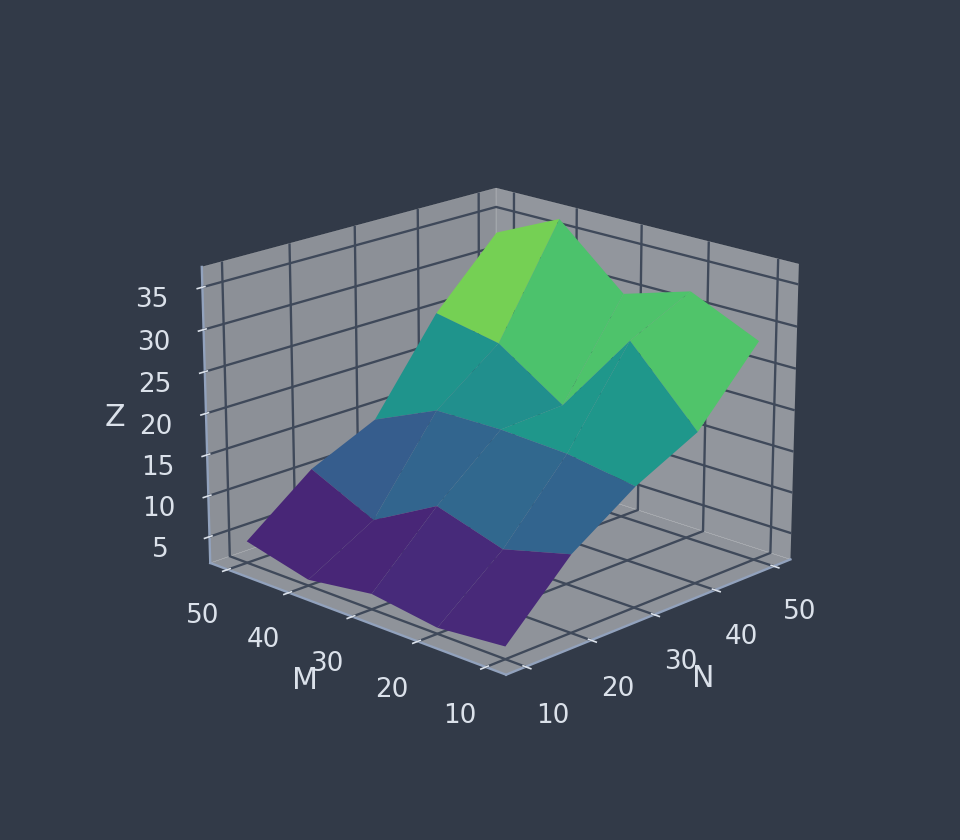

In [28]:
plot2dmetric('plurality_avg_steps')

<IPython.core.display.Javascript object>


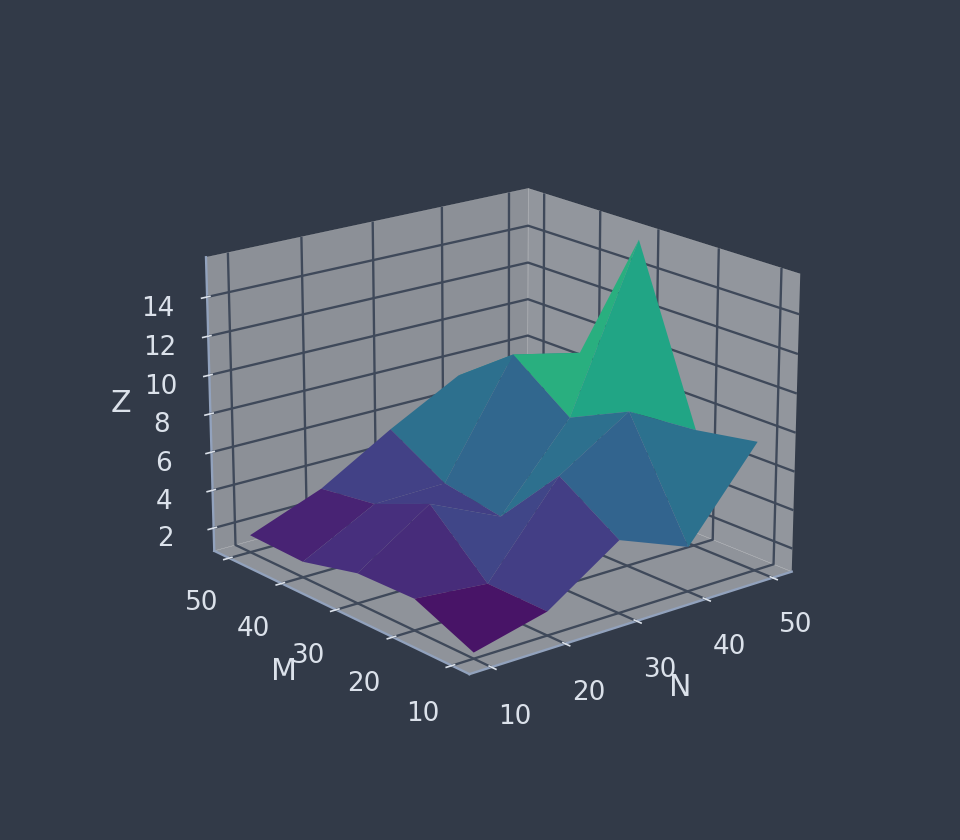

In [29]:
plot2dmetric('borda_avg_poa')

<IPython.core.display.Javascript object>


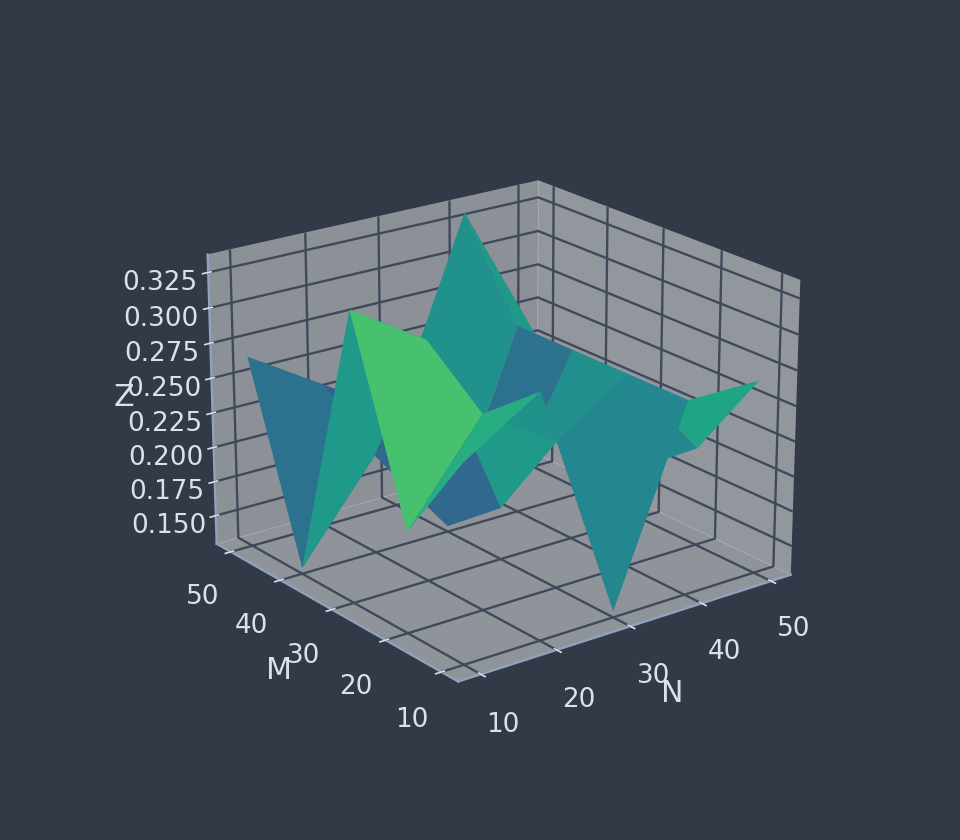

In [30]:
plot2dmetric('plurality_avg_poa')

In [33]:
#Tests
preferences = [
    [1 , 3 , 2 , 4],
    [2  , 1 , 3 ,4 ],
    [2 , 1 , 4 , 3],
    [3 , 1 , 4 , 2]
]

score_list : CandidateScores = {
    5 : 5,
    2 : 3,
    1 : 5
}

assert winner_from_scores(score_list) == 1
assert winner_from_scores(plurality(preferences)) == 2
assert winner_from_scores(borda(preferences)) == 1
assert u(preferences, 0, 3) == 2
places =  ranking_from_scores(score_list)
assert (5 in places[0] and 1 in places[0] and 2 in places[1]) 


preferences = [
    [1 , 3  ,4 , 5 ,2 ],
    [5, 1 , 3 , 2 , 4],
    [5, 1 , 3 , 2 , 4],
    [2  , 1 , 3 ,4 , 5 ],
    [2 , 1 , 4 , 3 , 5],
    [2 , 1 , 4 , 3 , 5],
    [3 , 1 , 4 , 2 , 5],
    [3 , 1 , 4 , 2 , 5]
]
places = ranking_from_scores(plurality(preferences))
assert 2 in places[0]
assert 5 in places[1] and 3 in places[1]
assert 1 in places[2]
assert swap_alternatives([1 , 2 , 3, 4] , 4 , 2) == [ 1, 4 , 3 , 2]

preferences = [
    [1 , 3  ,4 , 5 ,2 ],
    [2  , 1, 3 ,4 , 5 ],
    [2 , 1 , 4 , 3 , 5],
    [3 , 1 , 4 , 2 , 5],
    [3 , 2 , 4 , 1 , 5]
]
assert plurality_manipulation(preferences, preferences, 0 ) != None
# 3 can vote 1 instead and win (he prefers 1 over 2)
assert plurality_manipulation(preferences, preferences, 3 ) != None 
for v in [1,  2 ,4]:
    manip = plurality_manipulation(preferences, preferences, v )
    assert plurality_manipulation(preferences, preferences, v ) == None
    
preferences = [
    [1 , 3  ,4 , 5 ,2 ],
    [2  , 4, 5 ,1 , 3 ],
    [2 , 1 , 4 , 5 , 3],
    [3 , 2 , 4 , 1 , 2],
    [3 , 5 , 4 , 1 , 2]
]

assert borda_manipulation(preferences, preferences, 0) != None
# 4 can swap
for v in [1,2,3]:
    assert borda_manipulation(preferences, preferences, v) == None
assert best_response_dynamics(preferences, borda, borda_manipulation, 1000) != None
assert best_response_dynamics(preferences, plurality, plurality_manipulation, 1000) != None
best_response_dynamics(preferences, plurality, plurality_manipulation, 1000)

assert preferences_have_2_outcomes(preferences) == False
preferences = [
    [2 , 3  ,4 , 5 ,1 ],
    [2  , 4, 5 ,1 , 3 ],
    [2 , 1 , 4 , 5 , 3],
    [3 , 2 , 4 , 1 , 2],
    [3 , 5 , 4 , 1 , 2]
]
assert preferences_have_2_outcomes(preferences) == True
true_preferences = [
 [0, 2, 4, 1, 3],
 [4, 0, 1, 3, 2],
 [3, 1, 4, 2, 0],
 [4, 2, 0, 1, 3],
 [2, 4, 1, 0, 3]]
preferences = [
 [2, 0, 4, 1, 3],
 [4, 0, 1, 3, 2],
 [3, 1, 4, 2, 0],
 [4, 2, 0, 1, 3],
 [2, 4, 1, 0, 3]]
assert plurality_manipulation(true_preferences, preferences , 2 ) != None

true_prefs = \
[[4, 0, 2, 3, 1],
 [1, 4, 0, 2, 3],
 [3, 0, 1, 2, 4],
 [2, 4, 0, 3, 1],
 [2, 0, 3, 4, 1],
 [3, 4, 0, 2, 1],
 [0, 2, 1, 4, 3],
 [3, 0, 1, 2, 4],
 [1, 2, 3, 0, 4],
 [2, 4, 0, 3, 1]]
final_prefs = \
[[2, 0, 4, 3, 1],
 [1, 4, 0, 2, 3],
 [1, 0, 3, 4, 2],
 [2, 4, 0, 3, 1],
 [2, 0, 3, 4, 1],
 [2, 4, 0, 3, 1],
 [0, 2, 1, 4, 3],
 [1, 0, 3, 4, 2],
 [1, 2, 3, 0, 4],
 [2, 4, 0, 3, 1]]
#Final scores  {2: 27, 0: 25, 4: 18, 1: 18, 3: 12}

assert borda_manipulation(true_preferences,final_prefs, 1 ) != None